# Example Workflow for Normalizing and Validating δ15N Data from IRMS


## 1. SETUP

Define or import reference materials with known $\delta ^{15}N$ values for normalization and validation.


In [7]:
from isotools import USGS32_N2, USGS34_N2, USGS35_N2, ReferenceMaterial

# Custom reference materials can also be defined as needed
# USGSXXX = ReferenceMaterial("USGSXXX", true_value, uncertainty)

# for common use cases, materials can be added in isotools/standards.py

## 2. Ingest


In [8]:
from isotools import NitrogenProcessor

# Processor super class manages data cleaning, peak selection
# Implemented as a stateful object for future extensions in more complex workflows

# In this example, we exclude row 26 (a botched injection)
proc = NitrogenProcessor(exclude_rows=[26])

# Load the data from an Isodat report
# Some fields are mandatory for the processor to work properly
# Expecting one sheet per isotope for multiple isotopes runs (IE: NCS)
# Expecting "Peak Nr" to be consistent between runs, to discriminate between reference and sample peaks

df = proc.load_data(r"DATA\nitrate 26112025.xls", sheet_name="n_damian.wke")
df.head()

,row,sample_name,sample_id_2,amount,comment,peak_nr,amp_28,amp_29,area_28,area_29,r15n,d15n
3,10,nitrato ES3,NaN,0.558,NaN,2,5055,3592,71.990,0.511,0.003622,-15.346
5,11,nitrato ES3,NaN,0.588,NaN,2,5445,3867,78.306,0.556,0.003622,-15.414
7,12,nitrato ES3,NaN,0.592,NaN,2,5314,3774,77.983,0.554,0.003622,-15.287
9,13,nitrato ES3,NaN,0.559,NaN,2,4891,3474,71.222,0.506,0.003622,-15.412
11,14,nitrato ES6,NaN,0.487,NaN,2,5684,4128,83.973,0.610,0.003702,6.575


In [9]:
## .aggregate to aggregae replicate measurements

stats_df = proc.aggregate(df)
stats_df

,mean,sem,count
sample_name,,,
USGS32,188.14050,0.182134,4
USGS34,5.17925,0.023859,4
USGS35,9.80700,0.015716,3
nitrato ES3,-15.36475,0.030352,4
nitrato ES6,5.32700,0.866005,4


In [10]:
## .process_file to do full processing in one step

stats_df = proc.process_file(r"DATA\nitrate 26112025.xls", sheet_name="n_damian.wke")
stats_df

,mean,sem,count
sample_name,,,
USGS32,188.14050,0.182134,4
USGS34,5.17925,0.023859,4
USGS35,9.80700,0.015716,3
nitrato ES3,-15.36475,0.030352,4
nitrato ES6,5.32700,0.866005,4


## 3. Normalization and uncertainty calculation


In [11]:
from isotools import Calibrator, TwoPointStrategy

# Define calibration strategy
strategy = TwoPointStrategy()

# Initialize calibrator with strategy
calib = Calibrator(strategy=strategy)

# Perform normalization of the aggregate data
results = calib.calibrate(stats_df, standards=[USGS32_N2, USGS34_N2])
results

,mean,sem,count,corrected_delta,combined_uncertainty,true_value,is_standard,residual
sample_name,,,,,,,,
USGS32,188.14050,0.182134,4,180.000000,1.032202,180.0,True,0.000000e+00
USGS34,5.17925,0.023859,4,-1.800000,0.202791,-1.8,True,-9.547918e-15
USGS35,9.80700,0.015716,3,2.798378,0.198597,NaN,False,NaN
nitrato ES3,-15.36475,0.030352,4,-22.213608,0.253205,NaN,False,NaN
nitrato ES6,5.32700,0.866005,4,-1.653188,0.883727,NaN,False,NaN


AttributeError: 'str' object has no attribute 'identifier'

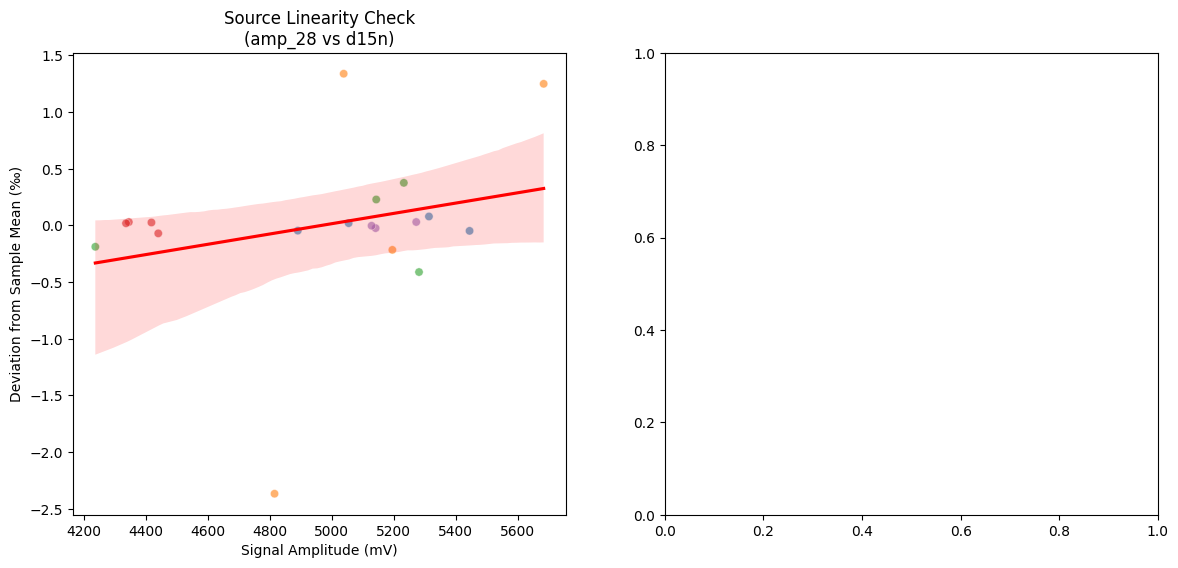

In [12]:
from isotools.visualization import plot_diagnostics

qc_standards = [USGS32_N2, USGS34_N2, USGS35_N2]

fig = plot_diagnostics(
    raw_df=df, results=results, standards=qc_standards, processor=proc
)